In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], False)

import os

import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

from loupe_keras import NetVLAD


def get_imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(u'.jpg')]


def create_image_dict(img_list):
    input_shape = (224, 224, 3)
    tensor = {}
    for path in img_list:
        img = image.load_img(path, target_size=(input_shape[0], input_shape[1]))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        img_key = path.strip('holidays_small/')
        tensor[img_key] = img
    # tensor = np.array(tensor)
    return tensor


Using TensorFlow backend.


In [2]:
img_dict = create_image_dict(get_imlist('holidays_small'))
img_dict.keys()

dict_keys(['138708.jpg', '134001.jpg', '138604.jpg', '107500.jpg', '124300.jpg', '123100.jpg', '122301.jpg', '115600.jpg', '130600.jpg', '101502.jpg', '141201.jpg', '146003.jpg', '128601.jpg', '106903.jpg', '139603.jpg', '101200.jpg', '118202.jpg', '112602.jpg', '139505.jpg', '121101.jpg', '113403.jpg', '108601.jpg', '138303.jpg', '133703.jpg', '148101.jpg', '131803.jpg', '132902.jpg', '130401.jpg', '123402.jpg', '104100.jpg', '139103.jpg', '106602.jpg', '106702.jpg', '122400.jpg', '106201.jpg', '106402.jpg', '139801.jpg', '117403.jpg', '142302.jpg', '111500.jpg', '118300.jpg', '121700.jpg', '137400.jpg', '101400.jpg', '132401.jpg', '106300.jpg', '146501.jpg', '139205.jpg', '134401.jpg', '126702.jpg', '132102.jpg', '138905.jpg', '105102.jpg', '112000.jpg', '120101.jpg', '106801.jpg', '138302.jpg', '134601.jpg', '113402.jpg', '133901.jpg', '139301.jpg', '112500.jpg', '148301.jpg', '119400.jpg', '104002.jpg', '147402.jpg', '109500.jpg', '137801.jpg', '141800.jpg', '132402.jpg', '109802.j

In [3]:
n_queries = 500

# create dataset
images = []
labels = []

labeled_file = open("labeled.dat", "r")
for line in labeled_file.readlines():
    split = line.split(" ")[:3]

    images.append(img_dict[split[0]])
    label_index = int(split[2])
    label = np.zeros(n_queries)
    label[label_index] = 1
    labels.append(label)

images = np.array(images)
labels = np.array(labels).astype('int32')
print(labels.shape)

(1491, 500)


In [4]:
# create model
from keras.applications import VGG16
from keras.models import Model
from keras import activations
import vis.utils.utils

input_shape = (224, 224, 3)

# vgg = VGG16(weights='imagenet', include_top=False, pooling=False, input_shape=input_shape)
vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)

# set layers untrainable
for layer in vgg.layers:
    layer.trainable = False
    # print(layer, layer.trainable)
    if layer.name is 'block5_conv2':
        layer.trainable = True

vgg.get_layer('block5_conv2').activation = activations.linear
vgg = vis.utils.utils.apply_modifications(vgg)

vgg = Model(vgg.input, vgg.get_layer('block5_conv2').output)

# vgg.layers.pop()
# vgg.layers.pop(0)

vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/home/fede/Documenti/netvlad/venv/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
all_descs = vgg.predict(images)

In [6]:
import random

all_descs_ = np.transpose(all_descs, axes=(0, 3, 1, 2))
all_descs_ = all_descs_.reshape((1491, 512, 14 * 14))

locals = []

for desc_matrix in all_descs_:
    samples = random.sample(desc_matrix.tolist(), 50)
    locals += samples

In [7]:
from sklearn.preprocessing import normalize

locals = np.array(locals)
locals = normalize(locals, axis=1)
locals.shape

(74550, 196)

In [8]:
from sklearn.cluster import MiniBatchKMeans

n_clust = 64
kmeans = MiniBatchKMeans(n_clusters=n_clust).fit(locals)

In [9]:
from keras.layers import Input, Dense, Reshape, Dropout, concatenate, Permute
from keras.optimizers import Adam
from keras.utils import plot_model
from triplet_loss import L2NormLayer

images_input = Input(shape=(224, 224, 3))
label_input = Input(shape=(n_queries,), name="input_label")

transpose = Permute((3, 1, 2), input_shape=(-1, 512))(vgg([images_input]))
embedding_size = 512

# vgg_output = vgg.output_shape[1]
# embedding = Dense(embedding_size, input_shape=(vgg_output,), activation='relu', name="embedding1")(vgg([images_input]))
reshape = Reshape((512, 14 * 14))(transpose)
l2normalization = L2NormLayer()(reshape)
netvlad = NetVLAD(feature_size=14 * 14, max_samples=512, cluster_size=64,
                  output_dim=1024)(l2normalization)  # , output_dim=1024)resnet_output = resnet.output_shape[1]

# netvlad_output = 8*8*64
netvlad_output = 14 * 14 * 64
dropout = Dropout(0.)

In [10]:
# embedding_output = netvlad(reshape(embedding(vgg.output)))
labels_plus_embeddings = concatenate([label_input, netvlad])

vgg_netvlad = Model(inputs=[images_input, label_input], outputs=labels_plus_embeddings)

In [26]:
netvlad_ = vgg_netvlad.get_layer('net_vlad_1')
weights_netvlad = netvlad_.get_weights()

In [27]:
cluster_weights = kmeans.cluster_centers_
alpha = 5.
assignments_weights = 2 * alpha * cluster_weights
assignments_bias = -alpha * np.sum(np.power(cluster_weights, 2), axis=1)

cluster_weights = cluster_weights.T
assignments_weights = assignments_weights.T
assignments_bias = assignments_bias.T

cluster_weights = np.expand_dims(cluster_weights, axis=0)
# assignments_weights = np.expand_dims(assignments_weights, axis=0)
# assignments_bias = np.expand_dims(assignments_bias, axis=0)

In [28]:
weights_netvlad[0] = assignments_weights
weights_netvlad[1] = assignments_bias
weights_netvlad[2] = cluster_weights

netvlad_.set_weights(weights_netvlad)
# vis.utils.utils.apply_modifications(vgg_netvlad)

In [29]:
plot_model(vgg_netvlad, to_file='base_network.png', show_shapes=True, show_layer_names=True)
vgg_netvlad.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 14, 14, 512)  12354880    input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 14, 14)  0           model_1[1][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 512, 196)     0           permute_1[0][0]                  
____________________________________________________________________________________________

In [30]:
result = vgg_netvlad.predict([images[:1], labels[:1]])

In [16]:
all_data_len = len(img_dict.keys())
# n_train = all_data_len
# n_train = 500

use_all = True
if not use_all:
    images_train = images[n_queries:]
    labels_train = labels[n_queries:]
else:
    images_train = images
    labels_train = labels

images_test = images[:n_queries]
labels_test = labels[:n_queries]

In [17]:
train = False
if train:
    from triplet_loss import TripletLossLayer, triplet_loss_adapted_from_tf_multidimlabels

    # from triplet_loss_ import batch_hard_triplet_loss_k
    batch_size = 256
    epochs = 96

    # train session
    opt = Adam(lr=0.0001)  # choose optimiser. RMS is good too!

    # loss_layer = TripletLossLayer(alpha=1., name='triplet_loss_layer')(vgg_netvlad.output)
    # vgg_qpn = Model(inputs=vgg_qpn.input, outputs=loss_layer)
    vgg_netvlad.compile(optimizer=opt, loss=triplet_loss_adapted_from_tf_multidimlabels)

    dummy_gt_train = np.zeros((len(images_train), netvlad_output + n_queries))
    dummy_gt_val = np.zeros((len(images_test), netvlad_output + n_queries))

    #%%

    H = vgg_netvlad.fit(
        x=[images_train, labels_train],
        y=dummy_gt_train,
        batch_size=batch_size,
        epochs=epochs,
        # validation_data=([images_test, labels_test], dummy_gt_val),
        verbose=1,
    )

    vgg_netvlad.save_weights("model.h5")
    print("Saved model to disk")

    plt.figure(figsize=(8, 8))
    plt.plot(H.history['loss'], label='training loss')
    # plt.plot(H.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Train/validation loss')
    plt.show()

In [18]:
# pop triplet loss layer
# resnet_qpn_no_loss = Model(input=resnet_qpn.input, outputs=resnet_qpn.output)
# resnet_qpn_no_loss.layers.pop()
# resnet_qpn_no_loss.summary()


In [31]:
# reload model from disk
# vgg_qpn = Model([input_q, input_p, input_n], [embedding_q, embedding_p, embedding_n])

# vgg_qpn.load_weights('model.h5')

result = vgg_netvlad.predict([images[:1], labels[:1]])

In [32]:
# test model

# this function create a perfect ranking :)

from sklearn.neighbors import NearestNeighbors

input_shape = (224, 224, 3)


def get_imlist_(path="holidays_small"):
    imnames = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(u'.jpg')]
    imnames = [path.strip('holidays_small/') for path in imnames]
    imnames = [path.strip('.jpg') for path in imnames]
    return imnames


def images_to_tensor(imnames):
    images_array = []

    # open all images
    for name in imnames:
        img_path = 'holidays_small/' + name + '.jpg'
        img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images_array.append(img)
    images_array = np.array(images_array)
    print(images_array.shape)
    # images_array = preprocess_input(images_array)
    return images_array


imnames = get_imlist_()

query_imids = [i for i, name in enumerate(imnames) if name[-2:].split('.')[0] == "00"]

# check that everything is fine - expected output: "tot images = 1491, query images = 500"
print('tot images = %d, query images = %d' % (len(imnames), len(query_imids)))

tot images = 1491, query images = 500


In [33]:
# img_tensor = images_to_tensor(imnames)
img_tensor = [img_dict[key] for key in img_dict]
img_tensor = np.array(img_tensor)

In [22]:
# vgg_netvlad.load_weights("model.h5")

ValueError: Shapes (3, 3, 512, 512) and (64, 3, 3, 3) are incompatible

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 14, 14, 512)  12354880    input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 14, 14)  0           model_1[1][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 512, 196)     0           permute_1[0][0]                  
____________________________________________________________________________________________

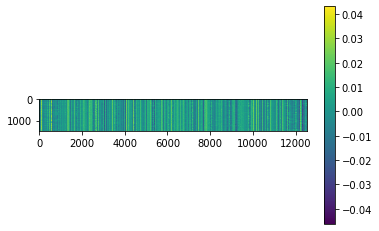

In [34]:
vgg_netvlad.summary()
all_feats = vgg_netvlad.predict([img_tensor, np.zeros((len(img_tensor), n_queries))])

all_feats = all_feats[:, n_queries:]

plt.imshow(all_feats, cmap='viridis')
plt.colorbar()
plt.grid(False)
plt.show()

In [35]:
query_feats = all_feats[query_imids]

# SOLUTION
nbrs = NearestNeighbors(n_neighbors=1491, metric='cosine').fit(all_feats)
distances, indices = nbrs.kneighbors(query_feats)


In [25]:
def make_perfect_holidays_result(imnames, q_ids):
    perfect_idx = []
    for qimno in q_ids:
        qname = imnames[qimno]
        positive_results = set([i for i, name in enumerate(imnames) if name != qname and name[:4] == qname[:4]])
        ok = [qimno] + [i for i in positive_results]
        others = [i for i in range(1491) if i not in positive_results and i != qimno]
        perfect_idx.append(ok + others)
    return np.array(perfect_idx)


def mAP(q_ids, idx):
    aps = []
    for qimno, qres in zip(q_ids, idx):
        qname = imnames[qimno]
        # collect the positive results in the dataset
        # the positives have the same prefix as the query image
        positive_results = set([i for i, name in enumerate(imnames)
                                if name != qname and name[:4] == qname[:4]])
        #
        # ranks of positives. We skip the result #0, assumed to be the query image
        ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
        #
        # accumulate trapezoids with this basis
        recall_step = 1.0 / len(positive_results)
        ap = 0
        for ntp, rank in enumerate(ranks):
            # ntp = nb of true positives so far
            # rank = nb of retrieved items so far
            # y-size on left side of trapezoid:
            precision_0 = ntp / float(rank) if rank > 0 else 1.0
            # y-size on right side of trapezoid:
            precision_1 = (ntp + 1) / float(rank + 1)
            ap += (precision_1 + precision_0) * recall_step / 2.0
        # print('query %s, AP = %.3f' % (qname, ap))
        aps.append(ap)
    return np.mean(aps)


print('mean AP = %.3f' % mAP(query_imids, indices))
perfect_result = make_perfect_holidays_result(imnames, query_imids)
print('Perfect mean AP = %.3f' % mAP(query_imids, perfect_result))

import PIL

import math


def montage(imfiles, thumb_size=(100, 100), ok=None, shape=None):
    # this function will create an image with thumbnailed version of imfiles.
    # optionally the user can provide an ok list such that len(ok)==len(imfiles) to differentiate correct from wrong results
    # optionally the user can provide a shape function which shapes the montage otherwise a square image is created.
    images = [PIL.Image.open(imname).resize(thumb_size, PIL.Image.BILINEAR) for imname in imfiles]
    # create a big image to contain all images
    if shape is None:
        n = int(math.sqrt(len(imfiles)))
        m = n
    else:
        n = shape[0]
        m = shape[1]
    new_im = PIL.Image.new('RGB', (m * thumb_size[0], n * thumb_size[0]))
    k = 0
    for i in range(0, n * thumb_size[0], thumb_size[0]):
        for j in range(0, m * thumb_size[0], thumb_size[0]):
            region = (j, i)
            if ok is not None:
                if ok[k]:
                    color = (0, 255, 0)
                else:
                    color = (255, 0, 0)
                if k > 0:
                    imar = np.array(images[k], dtype=np.uint8)
                    imar[0:5, :, :] = color
                    imar[:, 0:5, :] = color
                    imar[-5:, :, :] = color
                    imar[:, -5:, :] = color
                    images[k] = PIL.Image.fromarray(imar)
            new_im.paste(images[k], box=region)
            k += 1
    return new_im


mean AP = 0.029
Perfect mean AP = 1.000


In [ ]:
# here we show the first 25 queries and their 15 closest neighbours retrieved
# gree border means ok, red wrong :)
def show_result(display_idx, nqueries=10, nresults=10, ts=(100, 100)):
    if nqueries is not None:
        nrow = nqueries  # number of query images to show

    if nresults is not None:
        nres = 10  # number of results per query

    for qno in range(nrow):
        imfiles = []
        oks = [True]
        # show query image with white outline
        qimno = query_imids[qno]
        imfiles.append('holidays_small/' + imnames[qimno] + '.jpg')
        for qres in display_idx[qno, :nres]:
            # use image name to determine if it is a TP or FP result
            oks.append(imnames[qres][:4] == imnames[qimno][:4])
            imfiles.append('holidays_small/' + imnames[qres] + '.jpg')
        print(qno, (imfiles))
        plt.imshow(montage(imfiles, thumb_size=ts, ok=oks, shape=(1, nres)))
        plt.show()


In [ ]:
show_result(indices, nqueries=50)